<a href="https://colab.research.google.com/github/Abdullah-AlOwais/Tuwaiq/blob/main/Mini_Project_Week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras
import random
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)
random.seed(SEED)


In [135]:
!kaggle datasets download -d benoit72/uk-accidents-10-years-history-with-many-variables
!unzip uk-accidents-10-years-history-with-many-variables.zip

Dataset URL: https://www.kaggle.com/datasets/benoit72/uk-accidents-10-years-history-with-many-variables
License(s): CC0-1.0
uk-accidents-10-years-history-with-many-variables.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  uk-accidents-10-years-history-with-many-variables.zip
caution: filename not matched:  -y


In [185]:
#casual_df=pd.read_csv('/content/Casualties0514.csv',nrows=150000)
accident_df=pd.read_csv('/content/Accidents0514.csv',nrows=1000000)
#vehicle_df=pd.read_csv('/content/Vehicles0514.csv',nrows=200000)


In [186]:
from datetime import datetime
accident_df['Date'] = accident_df['Date'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y'))
accident_df = accident_df.sort_values(by=['Date'])

In [189]:
df =accident_df[['Date','Number_of_Casualties']]
df.set_index('Date', inplace=True)
df=df.loc['2005-01-01':'2009-12-31']
df= df.resample('D').sum()
dataset = df.values
dataset = dataset.astype('float32')

df

,Number_of_Casualties
Date,
2005-01-01,452
2005-01-02,468
2005-01-03,418
2005-01-04,599
2005-01-05,686
...,...
2009-12-27,342
2009-12-28,421
2009-12-29,391


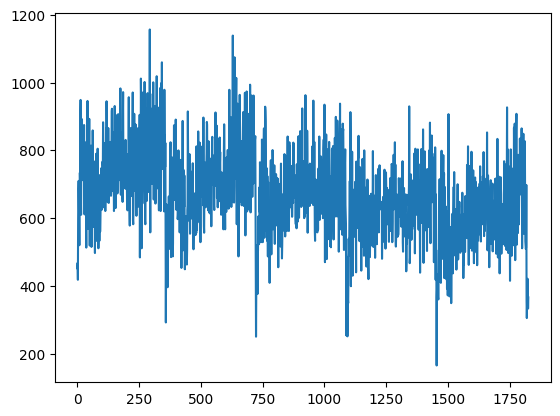

In [190]:
plt.plot(dataset)

In [250]:
def create_dataset(dataset, look_back=90):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [251]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

1460 366


In [252]:
model = Sequential()
model.add(LSTM(64, activation='tanh', return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0,2))
model.add(LSTM(32, activation='tanh',return_sequences=True))
model.add(Dropout(0,2))
model.add(LSTM(16, activation='tanh',return_sequences=True))
model.add(Dropout(0,2))
model.add(LSTM(8, activation='relu'))

model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_189 (LSTM)                      │ (None, 1, 64)               │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_149 (Dropout)                │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_190 (LSTM)                      │ (None, 1, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_150 (Dropout)                │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_191 (LSTM)                      │ (None, 1, 16)               │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_151 (Dropout)                │ (None, 1, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_192 (LSTM)                      │ (None, 8)                   │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,257 (129.91 KB)

 Trainable params: 33,257 (129.91 KB)

 Non-trainable params: 0 (0.00 B)

In [253]:
history = model.fit(trainX, trainY, epochs=30, batch_size=16, verbose=2)

Epoch 1/30
92/92 - 8s - 85ms/step - loss: 0.1542
Epoch 2/30
92/92 - 1s - 14ms/step - loss: 0.0115
Epoch 3/30
92/92 - 1s - 8ms/step - loss: 0.0113
Epoch 4/30
92/92 - 1s - 11ms/step - loss: 0.0112
Epoch 5/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 6/30
92/92 - 0s - 5ms/step - loss: 0.0112
Epoch 7/30
92/92 - 0s - 5ms/step - loss: 0.0112
Epoch 8/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 9/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 10/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 11/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 12/30
92/92 - 0s - 5ms/step - loss: 0.0112
Epoch 13/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 14/30
92/92 - 0s - 5ms/step - loss: 0.0112
Epoch 15/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 16/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 17/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 18/30
92/92 - 0s - 5ms/step - loss: 0.0112
Epoch 19/30
92/92 - 1s - 7ms/step - loss: 0.0112
Epoch 20/30
92/92 - 1s - 8ms/step - loss: 0.0112
Epoch 21/30
92/92 - 1s - 7

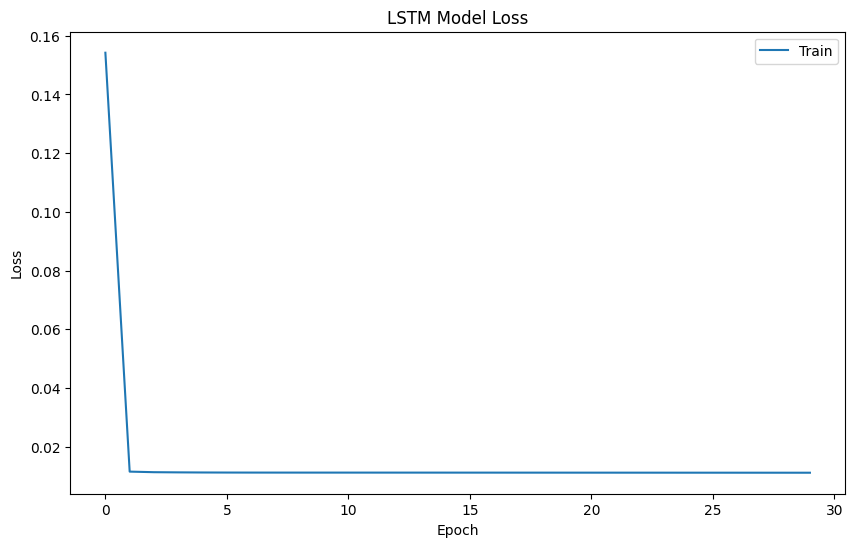

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Train Score: 0.11 RMSE
Test Score: 0.11 RMSE


In [254]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_pred = model.predict(X_val)
y_pred_inverse = scaler_y.inverse_transform(y_pred)
y_val_inverse = scaler_y.inverse_transform(y_val)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

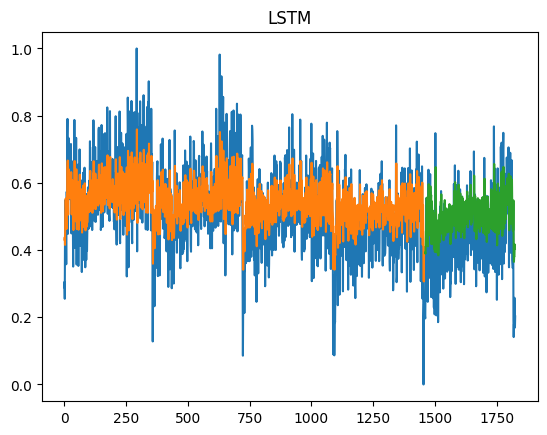

In [255]:

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.title('LSTM')
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [260]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

1460 366


In [261]:
model = Sequential()
model.add(GRU(128, return_sequences=True,input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0,2))
model.add(GRU(64))
model.add(Dropout(0,2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_14 (GRU)                         │ (None, 1, 128)              │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_154 (Dropout)                │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_15 (GRU)                         │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_155 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

In [262]:
GRUhistory = model.fit(trainX, trainY, epochs=30, batch_size=32, verbose=2)

Epoch 1/30
46/46 - 5s - 104ms/step - loss: 0.0626
Epoch 2/30
46/46 - 0s - 7ms/step - loss: 0.0113
Epoch 3/30
46/46 - 0s - 5ms/step - loss: 0.0110
Epoch 4/30
46/46 - 0s - 7ms/step - loss: 0.0110
Epoch 5/30
46/46 - 0s - 6ms/step - loss: 0.0110
Epoch 6/30
46/46 - 0s - 7ms/step - loss: 0.0110
Epoch 7/30
46/46 - 0s - 7ms/step - loss: 0.0110
Epoch 8/30
46/46 - 0s - 7ms/step - loss: 0.0110
Epoch 9/30
46/46 - 0s - 5ms/step - loss: 0.0110
Epoch 10/30
46/46 - 0s - 7ms/step - loss: 0.0110
Epoch 11/30
46/46 - 0s - 7ms/step - loss: 0.0110
Epoch 12/30
46/46 - 0s - 6ms/step - loss: 0.0110
Epoch 13/30
46/46 - 0s - 7ms/step - loss: 0.0110
Epoch 14/30
46/46 - 0s - 7ms/step - loss: 0.0110
Epoch 15/30
46/46 - 0s - 6ms/step - loss: 0.0110
Epoch 16/30
46/46 - 0s - 4ms/step - loss: 0.0110
Epoch 17/30
46/46 - 0s - 4ms/step - loss: 0.0110
Epoch 18/30
46/46 - 0s - 4ms/step - loss: 0.0111
Epoch 19/30
46/46 - 0s - 7ms/step - loss: 0.0111
Epoch 20/30
46/46 - 0s - 5ms/step - loss: 0.0111
Epoch 21/30
46/46 - 0s - 4m

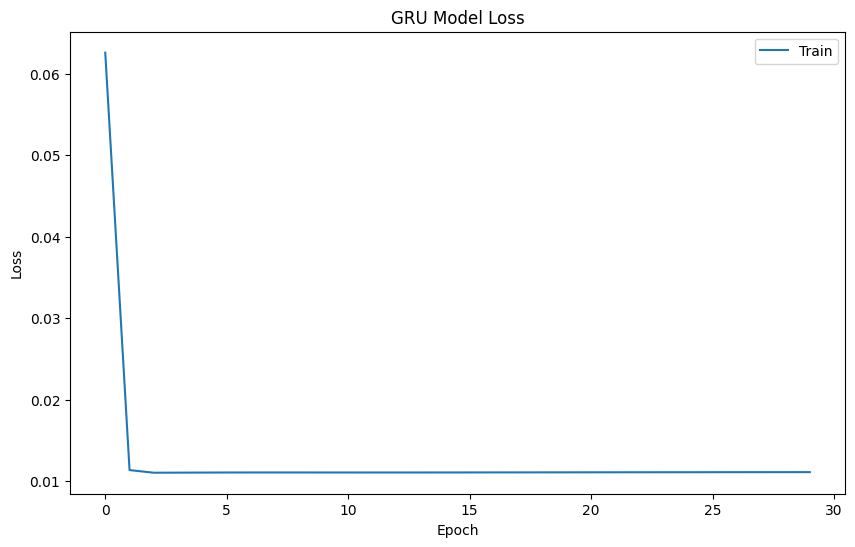

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 0.10 RMSE
Test Score: 0.11 RMSE


In [263]:
plt.figure(figsize=(10, 6))
plt.plot(GRUhistory.history['loss'], label='Train')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred = model.predict(X_val)
y_pred_inverse = scaler_y.inverse_transform(y_pred)
y_val_inverse = scaler_y.inverse_transform(y_val)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

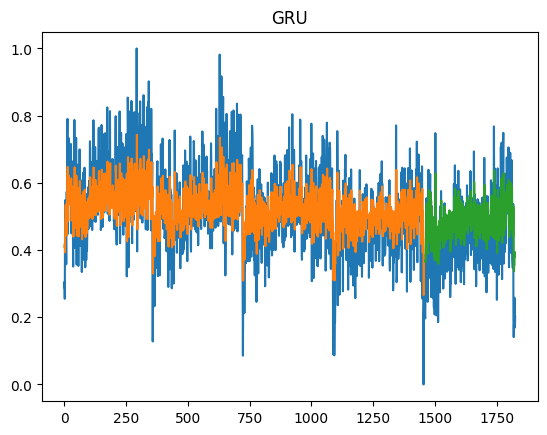

In [264]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

plt.title("GRU")
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()